**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Aprendizaje por Refuerzos**

*Edición 2022*

---

### *Integrantes:*
####  Porcel, Carolina
####  Sosa, Manuel

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

5. (Opcional) Implementar Dyna-Q a partir del algoritmo Q-Learning, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.


Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import gym


In [2]:
def plot_reward_per_episode(reward_ep):

    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

    plt.plot(reward_per_episode)
    plt.title('Recompensa acumulada por episodio')
    plt.show()
    
    
def plot_steps_per_episode(timesteps_ep):
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title('Pasos (timesteps) por episodio')
    plt.show()
    
    
def plot_steps_per_episode_smooth(timesteps_ep):
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [acumulated_steps[i] / episode_number[i] for i in range(len(acumulated_steps))]

    plt.plot(steps_per_episode)
    plt.title('Pasos (timesteps) acumulados por episodio')
    plt.show()
    

def draw_value_matrix(q):

    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):

            state_values = []

            for action in range(n_actions):
                state_values.append(q.get((row * n_columns + column, action), -100))

            maximum_value = max(state_values)  # determinamos la acción que arroja máximo valor


            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar) para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])):

        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = 'D'
        best_action = down_action

        if best_action < right_action:
            arrow_direction = 'R'
            best_action = right_action
        if best_action < left_action:
            arrow_direction = 'L'
            best_action = left_action
        if best_action < up_action:
            arrow_direction = 'U'
            best_action = up_action
        if best_action == -1:
            arrow_direction = ''

        # notar que column, row están invertidos en orden en la línea de abajo porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print('\n Matriz de mejor acción-valor (en números): \n\n', q_value_matrix)

## Set Up The Cliff

In [3]:
# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 2000

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [4]:
# Create the environment
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [5]:
env.action_space

Discrete(4)

The agent has 4 potential actions:

- UP = 0
- RIGHT = 1
- DOWN = 2
- LEFT = 3

Intentamos llegar a la meta manualmente.

In [6]:
env.reset()

36

In [7]:
env.step(2)

(36, -1, False, {'prob': 1.0})

In [8]:
def choose_action(state):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]  # ej: para 4 acciones inicializa en [0,0,0,0]
    max_q = max(q_values)

    if random_state.uniform() < epsilon:  # sorteamos un número: es menor a épsilon?
        return random_state.choice(actions)  # sí: se selecciona una acción aleatoria

    count = q_values.count(max_q)

    
    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [9]:
def learn(method, state, action, reward, next_state, next_action, 
          alpha = alpha , gamma = gamma):
    """
    Performs a SARSA update for a given state transition
    """
    if method == "sarsa":
      current = q.get((state, action),0.0)
      q_sa_next = q.get((next_state,next_action), 0.0) if next_state is not None else 0
      
      new_value = current + alpha*(reward + gamma*(q_sa_next) - current)
      
      q[(state,action)] = new_value

    elif method == "qlearning":
      q_values = [q.get((next_state, a), 0.0) for a in actions]
      max_q = max(q_values)
      current = q.get((state, action),0.0)

      new_value = current + alpha*(reward + (gamma*max_q) - current)
      q[(state,action)] = new_value
    pass

In [10]:
# def learn_qlearning(state, action, reward, next_state, next_action, method):


Finalmente, definimos el método principal de iteraciones. 

In [11]:
# from collections import defaultdict

# nA = env.action_space.n # num of actions

# # initialize empty dict of arrays
# q = defaultdict(lambda: np.zeros(nA))

In [12]:
def run(method):
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    global q
    q={}

    timesteps_of_episode = []  # registro de la cantidad de pasos que le llevó en cada episodio
    reward_of_episode = []  # cantidad de recompensa que recibió el agente en cada episodio

    for i_episode in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo llega a la salida
        # o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual
        action = choose_action(state)
        
        while not done:

            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(next_state)
            

            episode_reward += reward
            learn(method, state, action, reward, next_state, next_action)

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode, q

Ya instanciado, ejecutamos nuestro agente

## 1. Algoritmo SARSA

In [13]:
avg_steps_per_episode, timesteps_ep, reward_ep,q_sarsa = run("sarsa")

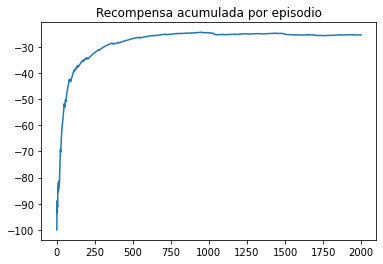

In [14]:
plot_reward_per_episode(reward_ep)

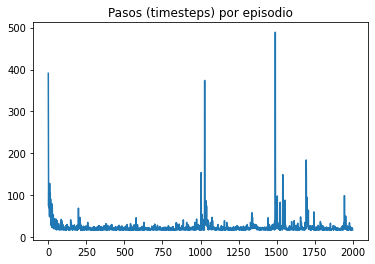

In [15]:
plot_steps_per_episode(timesteps_ep)

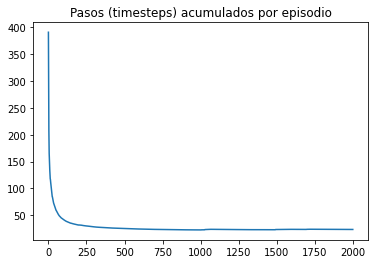

In [16]:
plot_steps_per_episode_smooth(timesteps_ep)

## 2. Algoritmo Q-Learning

In [17]:
avg_steps_per_episode_qlearning, timesteps_ep_qlearning, reward_ep_qlearning, q_qlearning = run("qlearning")

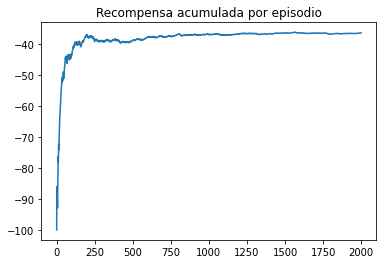

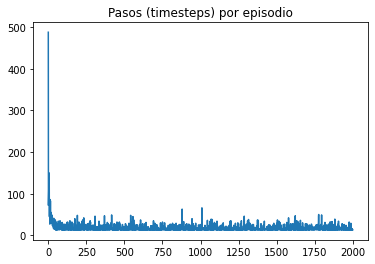

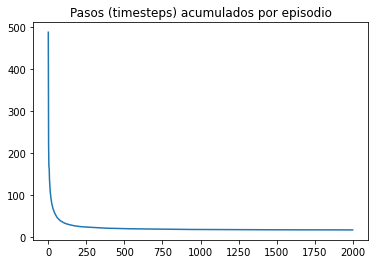

In [18]:
plot_reward_per_episode(reward_ep_qlearning)
plot_steps_per_episode(timesteps_ep_qlearning)
plot_steps_per_episode_smooth(timesteps_ep_qlearning)

#### Análisis de matriz de acción-valor y política óptima
Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función  Q(s,a)  para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política greedy). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el test de la política, frente al entrenamiento de la política previo).

SARSA


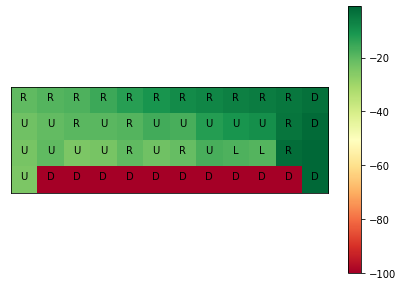


 Matriz de mejor acción-valor (en números): 

 [[ -20.14576413  -18.74323745  -17.94836622  -15.51293673  -12.76930709
   -10.56708351   -8.57327744   -7.22158389   -6.37053214   -5.52322137
    -4.34697675   -3.08670353]
 [ -22.43706292  -20.59562506  -19.27095528  -19.54827595  -18.5430603
   -16.29443127  -17.09120264  -12.28279812  -10.32208512   -9.4121788
    -3.99616835   -2.00000124]
 [ -23.75953398  -20.08707052  -24.33836794  -23.69672627  -20.03427147
   -22.39541537  -20.81126349  -16.85708246  -17.66582055  -18.55774698
    -2.53772953   -1.        ]
 [ -24.39230823 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [19]:
print("SARSA")

draw_value_matrix(q_sarsa)

QLEARNING


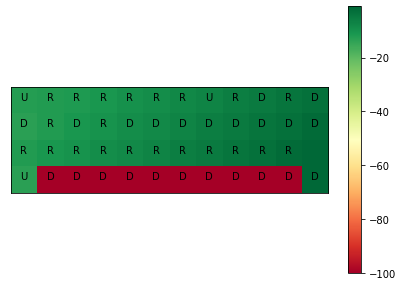


 Matriz de mejor acción-valor (en números): 

 [[ -12.57749042  -12.09385878  -11.44740085  -10.71193601   -9.8018862
    -8.8591378    -7.90269145   -6.92620721   -5.9852524    -4.99202539
    -3.99840884   -2.99999908]
 [ -12.99999999  -12.          -11.          -10.           -9.
    -8.           -7.           -6.           -5.           -4.
    -3.           -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [20]:
print("QLEARNING")
draw_value_matrix(q_qlearning)

Q-learning aprende valores para la política óptima, la que viaja justo al borde del precipicio. Desafortunadamente, esto da como resultado que ocasionalmente se caiga por el precipicio. SARSA, por otro lado, tiene en cuenta la selección de acciones y aprende el camino más largo pero más seguro a través de la fila más alejada del precipicio. 
En cuanto a la convergencia, el rendimiento de SARSA tiene mejor desempeño (converge en -30) versus el rendimiento de Q-LEARNING (converge en -40).

## 3. Ajustando Hiperparámetros

Crear grilla hiperparametros

In [21]:
from itertools import product
list_alpha = [0.1,0.25,0.75,0.9]
list_gamma = [0.25,0.5,0.75,1]
list_epsilon = [0.01,0.1,0.3,0.5]

method_list = ["sarsa","qlearning"]

grid = [*product(list_alpha, list_gamma, list_epsilon)]

In [22]:
episodes_to_run = 1500

In [23]:
from tqdm import tqdm_notebook

columns = ["alpha","gamma","epsilon", "mean_reward", "last_reward", "timestep_mean"]
index = pd.MultiIndex.from_tuples([*product(range(len(grid)), method_list)])
results = pd.DataFrame(columns = columns, index = index)


for idx, (alpha,gamma,epsilon) in tqdm_notebook(enumerate(grid)):
  for met in method_list:  
    avg_steps_per_episode, timesteps_ep, reward_ep, q = run(method = met)
    results.loc[(idx, met), columns] = [alpha,gamma,epsilon, reward_ep.mean(), reward_ep[-1], timesteps_ep.mean()]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

In [24]:
results = results.sort_values("mean_reward", ascending = False)
results.iloc[:60, :]

,,alpha,gamma,epsilon,mean_reward,last_reward,timestep_mean
20,qlearning,0.25,0.5,0.01,-15.819333,-13.0,14.548667
52,qlearning,0.9,0.5,0.01,-15.930667,-13.0,14.558
0,qlearning,0.1,0.25,0.01,-16.055333,-14.0,14.582667
12,qlearning,0.1,1,0.01,-16.082667,-13.0,14.606667
48,qlearning,0.9,0.25,0.01,-16.150667,-13.0,14.59
24,qlearning,0.25,0.75,0.01,-16.228,-13.0,14.572
40,qlearning,0.75,0.75,0.01,-16.315333,-13.0,14.592667
4,qlearning,0.1,0.5,0.01,-16.378,-13.0,14.604667
56,qlearning,0.9,0.75,0.01,-16.511333,-100.0,14.616
36,qlearning,0.75,0.5,0.01,-16.587333,-13.0,14.672667


Realizando todas las combinaciones de hiperparámetros, más bajos y más altos que los definidos inicialmente, se puede observar que los modelos que mejor reward tienen, y de hecho obtienen la politica optima son los que menor **EPSILON** tienen. Este parece ser el parámetro clave. Un epsilon bajo, permite explorar más alternativas hasta encontrar la politica óptima.

#### Para interpretar los resultados, graficamos los mejores modelos

['qlearning', 0.25, 0.5, 0.01]


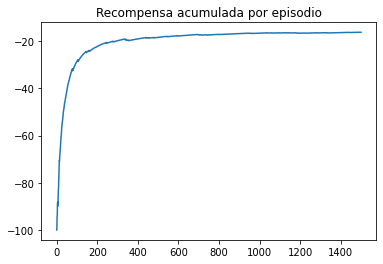

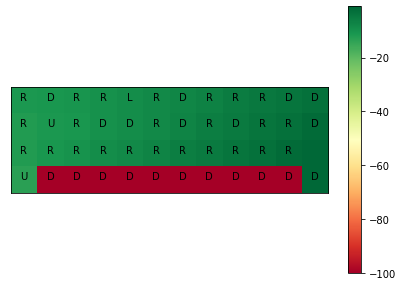


 Matriz de mejor acción-valor (en números): 

 [[ -11.39778972  -10.93847588  -10.29875775   -9.63451447   -8.92195167
    -8.12456952   -7.22103181   -6.47927966   -5.57609169   -4.76367401
    -3.83895178   -2.98458132]
 [ -11.90176219  -11.3039302   -10.6895846    -9.79780803   -8.94252946
    -7.97981779   -6.99117914   -5.99546008   -4.99737084   -3.99902185
    -2.99985159   -1.99999996]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]

 

['qlearning', 0.9, 0.5, 0.01]


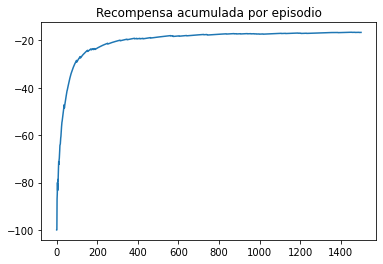

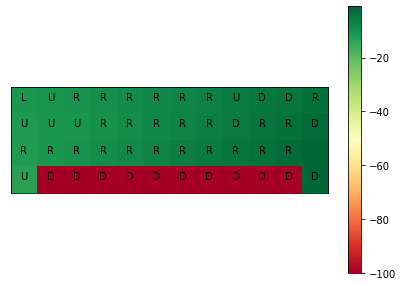


 Matriz de mejor acción-valor (en números): 

 [[ -11.11152201  -10.52268931  -10.00980269   -9.49943992   -8.6608014
    -7.91727851   -7.2198407    -6.31307735   -5.42288208   -4.59321226
    -3.80398553   -2.96875   ]
 [ -11.51971041  -11.1209071   -10.4219138    -9.82008037   -8.87417563
    -7.91876216   -6.96903204   -5.98780432   -4.99794837   -3.99924093
    -2.99983179   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]

 

['qlearning', 0.1, 0.25, 0.01]


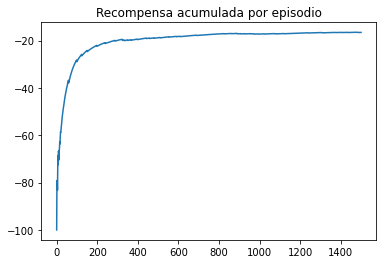

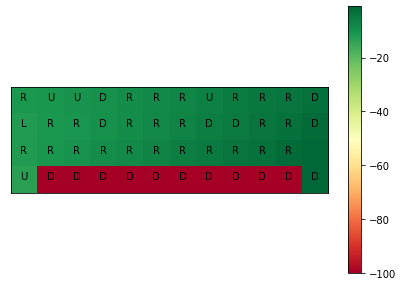


 Matriz de mejor acción-valor (en números): 

 [[ -11.34331529  -10.70572816  -10.21569843   -9.58119302   -8.78012331
    -8.04465092   -7.22643791   -6.34503651   -5.5140509    -4.63782117
    -3.80399318   -2.96581357]
 [ -11.89697691  -11.17195347  -10.36860551   -9.58133532   -8.80133481
    -7.90010957   -6.94748472   -5.96808772   -4.99542325   -3.99804384
    -2.99922824   -1.99999977]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]

 

['qlearning', 0.1, 1, 0.01]


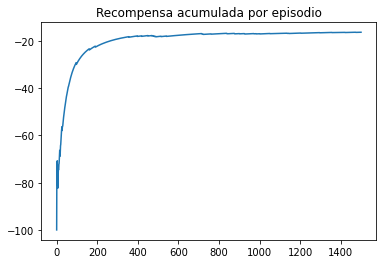

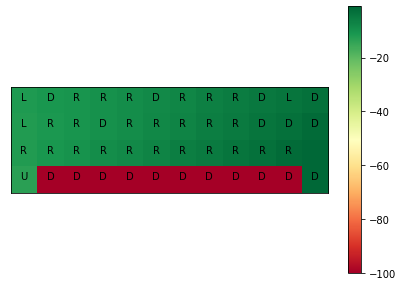


 Matriz de mejor acción-valor (en números): 

 [[ -11.53840592  -11.0163659   -10.41918619   -9.67553124   -8.88941539
    -8.04054748   -7.2208008    -6.32941503   -5.49484394   -4.5965224
    -3.85449219   -2.97797412]
 [ -11.96273998  -11.33945718  -10.56616035   -9.74269104   -8.83255731
    -7.88599464   -6.93180681   -5.97277953   -4.98960686   -3.99583975
    -2.99971949   -1.99999998]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]

 



In [25]:
for (method, alpha,gamma,epsilon) in results.reset_index(level = 1).iloc[:4, :4].values:
    print([method, alpha,gamma, epsilon])
    avg_steps_per_episode, timesteps_ep, reward_ep, q = run(method = met)
    plot_reward_per_episode(reward_ep)
    draw_value_matrix(q)
    print("\n \n")